<a href="https://colab.research.google.com/github/johngachara/credit_card_fraud_detection/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler,LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from tensorflow.keras.regularizers import l1_l2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import randint
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [19]:
# Try setting a different quote character or escape character
'''
Quote Character: The quotechar parameter specifies the character used to denote the beginning and end of string fields within the CSV file. By default, it is set to double quotes ("). If your CSV file uses a different character for quoting strings (e.g., single quotes '), you need to adjust this parameter accordingly.

Escape Character: The escapechar parameter defines the character used to escape special characters within string fields, including the quote character itself. If your CSV file uses a different escape character, you need to specify it here.
'''
train_data = pd.read_csv('fraudTrain.csv', quotechar='"', escapechar='\\')
test_data = pd.read_csv('fraudTest.csv', quotechar='"', escapechar='\\')
data = pd.concat([train_data, test_data])
# Separate majority and minority classes
df_majority = data[data['is_fraud'] == 0]
df_minority = data[data['is_fraud'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # Sample without replacement
                                   n_samples=len(df_minority),  # Match minority class
                                   random_state=42)  # Reproducible results

# Combine minority class and downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
data = df_downsampled
# Display class counts
print(df_downsampled['is_fraud'].value_counts())

is_fraud
0.0    2032
1.0    2032
Name: count, dtype: int64


In [20]:
useless_cols = [
    'Unnamed: 0',
    'merchant',
    'cc_num',
    'first',
    'zip',
    'last',
    'trans_num',
    'unix_time',
    'street',
    'merch_lat',
    'gender',
    'merch_long',
    'job',
    'trans_date_trans_time'
]
data.drop(columns=useless_cols, inplace=True)

In [21]:
#train_data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4064 entries, 96364 to 147273
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  4064 non-null   object 
 1   amt       4064 non-null   float64
 2   city      4064 non-null   object 
 3   state     4064 non-null   object 
 4   lat       4064 non-null   float64
 5   long      4064 non-null   float64
 6   city_pop  4064 non-null   float64
 7   dob       4064 non-null   object 
 8   is_fraud  4064 non-null   float64
dtypes: float64(5), object(4)
memory usage: 317.5+ KB


category    0
amt         0
city        0
state       0
lat         0
long        0
city_pop    0
dob         0
is_fraud    0
dtype: int64

In [22]:
data.isnull().sum()

category    0
amt         0
city        0
state       0
lat         0
long        0
city_pop    0
dob         0
is_fraud    0
dtype: int64

In [23]:
data.duplicated().sum()

0

In [ ]:
data.drop_duplicates(inplace=True)

In [24]:
data["dob"] = pd.to_datetime(data["dob"])
data["dob"] = data["dob"].dt.year
data['dob'] = datetime.now().year - data['dob']
data = data.rename(columns = {"dob" : "age"})
data.head()

,category,amt,city,state,lat,long,city_pop,age,is_fraud
96364,shopping_pos,380.75,Greenview,CA,41.5403,-122.9366,308.0,66,0.0
41485,misc_pos,1.44,Fullerton,NE,41.3660,-98.0054,1749.0,51,0.0
86248,gas_transport,62.98,Louisiana,MO,39.4336,-91.0664,4593.0,84,0.0
116539,gas_transport,82.13,Cedar,MI,44.8605,-85.8138,3096.0,49,0.0
106723,grocery_net,58.45,Darien,GA,31.3826,-81.4312,5989.0,57,0.0


In [25]:
def find_outliers(dataset, threshold=3):
    mean = dataset.mean()
    std = dataset.std()
    z_scores = (dataset - mean) / std
    outliers = dataset[np.abs(z_scores) > threshold]
    return outliers

In [26]:
numerical_features = ['amt','city_pop']
# Find and print outliers for each numerical feature
for feature in numerical_features:
    outliers = find_outliers(data[feature])
    print(f"Outliers in '{feature}':")
    print(outliers)
    print("\n")

Outliers in 'amt':
99158    2393.29
82742    2458.64
Name: amt, dtype: float64


Outliers in 'city_pop':
106393    1312922.0
65166     1382480.0
119523    1595797.0
98206     2906700.0
2031      1595797.0
            ...    
114547     927396.0
114586     927396.0
114638     927396.0
149880    1577385.0
150226    1577385.0
Name: city_pop, Length: 94, dtype: float64




In [27]:
def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    capped_series = series.clip(lower=lower_bound, upper=upper_bound) #clip directly modifies the dataset
    return capped_series

In [28]:
# Create a new DataFrame to store capped data
capped_data = data.copy()

# Iterate through numerical features and apply capping function
for feature in numerical_features:
    capped_data[feature] = cap_outliers_iqr(data[feature])

# Print the capped data
capped_data.head()

,category,amt,city,state,lat,long,city_pop,age,is_fraud
96364,shopping_pos,380.75,Greenview,CA,41.5403,-122.9366,308.0,66,0.0
41485,misc_pos,1.44,Fullerton,NE,41.3660,-98.0054,1749.0,51,0.0
86248,gas_transport,62.98,Louisiana,MO,39.4336,-91.0664,4593.0,84,0.0
116539,gas_transport,82.13,Cedar,MI,44.8605,-85.8138,3096.0,49,0.0
106723,grocery_net,58.45,Darien,GA,31.3826,-81.4312,5989.0,57,0.0


In [29]:
for feature in numerical_features:
    outliers = find_outliers(capped_data[feature])
    print(f"Outliers in '{feature}':")
    print(outliers)
    print("\n")

Outliers in 'amt':
Series([], Name: amt, dtype: float64)


Outliers in 'city_pop':
Series([], Name: city_pop, dtype: float64)




In [30]:
#train_data.drop(columns=['trans_date_trans_time','trans_num','first','last','dob'],inplace=True)
categorical_features = capped_data.select_dtypes(exclude=['int64', 'float64','int32'])
numeric_colums = capped_data.select_dtypes(include=['int64', 'float64','int32'])
print(categorical_features.columns)
print(numeric_colums.columns)

Index(['category', 'city', 'state'], dtype='object')
Index(['amt', 'lat', 'long', 'city_pop', 'age', 'is_fraud'], dtype='object')


In [31]:
encoder = LabelEncoder()
for col in categorical_features.columns:
    capped_data[col] = encoder.fit_transform(capped_data[col])

capped_data.head()

,category,amt,city,state,lat,long,city_pop,age,is_fraud
96364,12,380.75,253,4,41.5403,-122.9366,308.0,66,0.0
41485,9,1.44,228,28,41.3660,-98.0054,1749.0,51,0.0
86248,2,62.98,383,23,39.4336,-91.0664,4593.0,84,0.0
116539,2,82.13,108,21,44.8605,-85.8138,3096.0,49,0.0
106723,3,58.45,161,9,31.3826,-81.4312,5989.0,57,0.0


In [32]:
scaler = StandardScaler()
columns = capped_data.columns.tolist()
columns.remove('is_fraud')
X = capped_data.drop(['is_fraud'], axis=1)
y = capped_data['is_fraud']
X[columns] = scaler.fit_transform(X[columns])
capped_data[X.columns] = X

In [33]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()
}

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #cm = confusion_matrix(y_test, y_pred)
    return accuracy #cm

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
results = {}
for name, model in models.items():
    accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {
        'Accuracy': accuracy

    }
# Create a DataFrame to display the results
results_df = pd.DataFrame(results).T
results_df

,Accuracy
Logistic Regression,0.849938
Decision Tree,0.948339
Random Forest,0.958180
Gradient Boosting,0.953260
KNN,0.846248


In [37]:
def hyperparameter_tune(model_name, params, X, y):
    model = models[model_name]  # Get the model from the 'models' dictionary
    grid_search_cv = GridSearchCV(model, params)
    grid_search_cv.fit(X, y)
    print(f"The best hyperparameters for {model_name} are: ", grid_search_cv.best_params_)
    return grid_search_cv.best_estimator_

In [30]:
# Logistic Regression
params_logistic = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}

# Decision Tree (already provided in the original code)
params_dt = {'max_depth': range(2,10), 'min_samples_split': range(2,10), 'min_samples_leaf': range(2,10)}

# Random Forest
params_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# Gradient Boosting
params_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}

# KNN
params_knn = {'n_neighbors': range(3, 11), 'weights': ['uniform', 'distance']}

In [31]:
best_logistic_model = hyperparameter_tune('Logistic Regression', params_logistic, X, y)
best_rf_model = hyperparameter_tune('Random Forest', params_rf, X, y)
best_gb_model = hyperparameter_tune('Gradient Boosting', params_gb, X, y)
best_knn_model = hyperparameter_tune('KNN', params_knn, X, y)
best_dt_model = hyperparameter_tune('Decision Tree', params_dt, X, y)

The best hyperparameters for Logistic Regression are:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
The best hyperparameters for Random Forest are:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


KeyboardInterrupt: 

In [ ]:
tuned_models = {
    'Logistic Regression': best_logistic_model,
    'Decision Tree': best_dt_model,
    'Random Forest': best_rf_model,
    'Gradient Boosting': best_gb_model,
    'KNN': best_knn_model
}

In [ ]:
tuned_results = {}
for name, model in tuned_models.items():
    accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
    tuned_results[name] = {
        'Accuracy': accuracy

    }
# Create a DataFrame to display the results
tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df

,Accuracy
Logistic Regression,0.864534
Decision Tree,0.953904
Random Forest,0.954845
Gradient Boosting,0.970837
KNN,0.811853


In [ ]:
def hyperparameter_tune_random(model_name, params, X, y, n_iter=10):
    model = models[model_name]
    random_search_cv = RandomizedSearchCV(model, params, n_iter=n_iter)
    random_search_cv.fit(X, y)
    print(f"The best hyperparameters for {model_name} are: ", random_search_cv.best_params_)
    return random_search_cv.best_estimator_

In [ ]:
best_logistic_model = hyperparameter_tune_random('Logistic Regression', params_logistic, X, y)
best_rf_model = hyperparameter_tune_random('Random Forest', params_rf, X, y)
best_gb_model = hyperparameter_tune_random('Gradient Boosting', params_gb, X, y)
best_knn_model = hyperparameter_tune_random('KNN', params_knn, X, y)
best_dt_model = hyperparameter_tune_random('Decision Tree', params_dt, X, y)

The best hyperparameters for Logistic Regression are:  {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
The best hyperparameters for Random Forest are:  {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': None}
The best hyperparameters for Gradient Boosting are:  {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1}
The best hyperparameters for KNN are:  {'weights': 'uniform', 'n_neighbors': 8}
The best hyperparameters for Decision Tree are:  {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 7}


In [ ]:
tuned_results = {}
for name, model in tuned_models.items():
    accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
    tuned_results[name] = {
        'Accuracy': accuracy

    }
# Create a DataFrame to display the results
tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df

,Accuracy
Logistic Regression,0.864534
Decision Tree,0.954845
Random Forest,0.948260
Gradient Boosting,0.968956
KNN,0.811853


In [ ]:
joblib.dump(best_logistic_model, 'logistic_regression_model.pkl')
joblib.dump(best_dt_model, 'decision_tree_model.pkl')
joblib.dump(best_rf_model, 'random_forest_model.pkl')
joblib.dump(best_gb_model, 'gradient_boosting_model.pkl')
joblib.dump(best_knn_model, 'knn_model.pkl')

['knn_model.pkl']

In [38]:
X_train.shape

(3251, 8)

In [69]:
neural_net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
neural_net.summary()
optimizer = Adam(learning_rate=0.001)
 # Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
neural_net.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               1152      
                                                                 
 batch_normalization_18 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_19 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 64)               

In [82]:
history = neural_net.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping,lr_scheduler])

Epoch 1/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2387 - accuracy: 0.8996 - val_loss: 0.2143 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 2/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2405 - accuracy: 0.9015 - val_loss: 0.2144 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 3/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2225 - accuracy: 0.9115 - val_loss: 0.2072 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 4/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2382 - accuracy: 0.9000 - val_loss: 0.2054 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 5/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2203 - accuracy: 0.9104 - val_loss: 0.2047 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 6/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2340 - accuracy: 0.9108 - val_loss: 0.2215 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 7/150
82/82 [==============================] - 1s 8ms/step - loss: 0.2

In [83]:
y_pred_proba = neural_net.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")

26/26 [==============================] - 0s 2ms/step
Accuracy: 0.9237
Precision: 0.9123
Recall: 0.9309
F1-Score: 0.9215
AUC-ROC: 0.9768
False Positive Rate: 0.0829
False Negative Rate: 0.0691


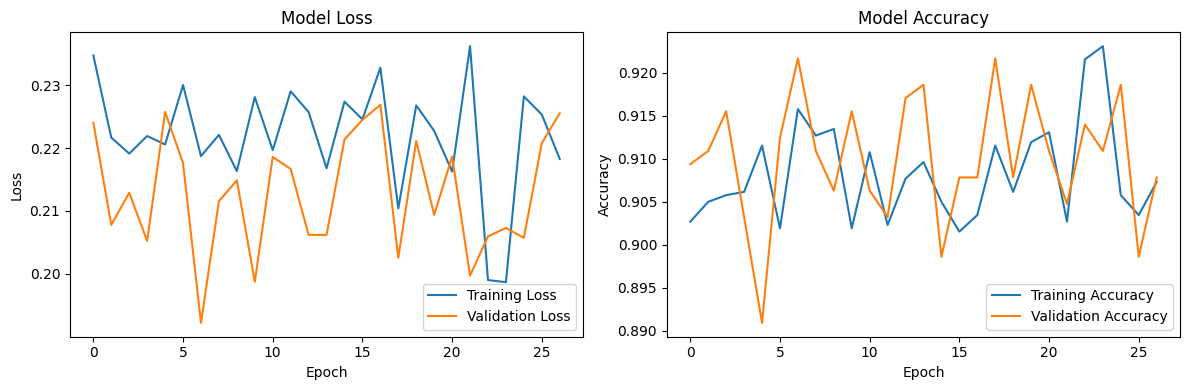

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
import keras_tuner as kt
from tensorflow import keras
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units_1', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(hp.Float('l2_1', min_value=0.001, max_value=0.1, sampling='log')),
        input_shape=(8,)
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(keras.layers.Dense(
        units=hp.Int('units_2', min_value=8, max_value=32, step=8),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(hp.Float('l2_2', min_value=0.001, max_value=0.1, sampling='log'))
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [57]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='fraud_detection'
)

tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")
model = tuner.hypermodel.build(best_hps)

Trial 50 Complete [00h 01m 13s]
val_accuracy: 0.868078202009201

Best val_accuracy So Far: 0.8827361464500427
Total elapsed time: 00h 41m 52s
Best hyperparameters: {'units_1': 64, 'l2_1': 0.06254165196547186, 'dropout_1': 0.5, 'units_2': 8, 'l2_2': 0.010148290451738852, 'dropout_2': 0.1, 'learning_rate': 0.008814539763107558}


In [72]:
history = model.fit(X_train, y_train, epochs=150, batch_size=8, validation_split=0.2, callbacks=[early_stopping,lr_scheduler])

Epoch 1/150
77/77 [==============================] - 0s 5ms/step - loss: 0.5126 - accuracy: 0.7840 - val_loss: 0.4425 - val_accuracy: 0.8143 - lr: 0.0088
Epoch 2/150
77/77 [==============================] - 0s 5ms/step - loss: 0.5277 - accuracy: 0.7791 - val_loss: 0.4519 - val_accuracy: 0.8078 - lr: 0.0088
Epoch 3/150
77/77 [==============================] - 0s 4ms/step - loss: 0.5074 - accuracy: 0.7840 - val_loss: 0.4234 - val_accuracy: 0.8241 - lr: 0.0088
Epoch 4/150
77/77 [==============================] - 0s 4ms/step - loss: 0.5136 - accuracy: 0.7857 - val_loss: 0.4559 - val_accuracy: 0.7915 - lr: 0.0088
Epoch 5/150
77/77 [==============================] - 0s 4ms/step - loss: 0.5050 - accuracy: 0.7946 - val_loss: 0.4319 - val_accuracy: 0.7948 - lr: 0.0088
Epoch 6/150
77/77 [==============================] - 0s 4ms/step - loss: 0.5231 - accuracy: 0.7840 - val_loss: 0.4365 - val_accuracy: 0.8664 - lr: 0.0088
Epoch 7/150
77/77 [==============================] - 0s 5ms/step - loss: 0.5